In [38]:
from model.deeponet import *
import numpy as np
from src.collision_operator_1D import CollisionOperator1D
from src.collision_operator_3D import CollisionOperator3D
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader

In [39]:
gpu_id='3'
import os
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_id

use_cuda = torch.cuda.is_available()
print("Is available to use cuda? : ",use_cuda)
if use_cuda:
    print("-> GPU number ",gpu_id)

Is available to use cuda? :  True
-> GPU number  3


## 1D case

In [40]:
dimension=1
names=[
    'wo_bias',
    'w_bias',
    'soft_lamb01',
    'hard_gram',
    'hard_special',
]
list_filename=[
    '3_64_3_64_wo_bias',
    '3_64_3_64_w_bias',
    '3_64_3_64_soft_lamb01',
    '3_64_3_64_hard_gram',
    '3_64_3_64_hard_special'
]

In [41]:
args=torch.load(f'results/{dimension}D/'+'entropy/'+list_filename[0]+'/args.bin')
gparams = args.__dict__

In [42]:
### Data
## Load data
train_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_train_data.npz')
test_data=np.load('data/'+f'{dimension}D/'+gparams['data_file']+'_test_data.npz')

train_data_f, train_data_Q = torch.FloatTensor(train_data['data_f']), torch.FloatTensor(train_data['data_Q'])
test_data_f, test_data_Q = torch.FloatTensor(test_data['data_f']), torch.FloatTensor(test_data['data_Q'])

resol=train_data_f.shape[-1]
num_train=train_data_f.shape[0]
num_test=test_data_f.shape[0]

if gparams['batch_size']==0:
    batch_size_train=num_train
else:
    batch_size_train = gparams['batch_size']

## Train data
dataset=TensorDataset(train_data_f.unsqueeze(1),train_data_Q)
train_dataloader = DataLoader(dataset, batch_size=batch_size_train, shuffle=True)

## Test data
batch_size_test = num_test
dataset=TensorDataset(test_data_f.unsqueeze(1),test_data_Q)
test_dataloader = DataLoader(dataset, batch_size=batch_size_test, shuffle=False)

## guad pts and weights
integration_order=gparams['integration_order']
if dimension==1:
    Q = CollisionOperator1D(integration_order)
    grid = torch.FloatTensor(Q.get_quad_pts()).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())
elif dimension==3:
    Q = CollisionOperator3D(integration_order)
    grid = torch.FloatTensor(Q.get_quad_pts().transpose(1,2,0)).reshape(-1,dimension).cuda()
    quad_w = torch.FloatTensor(Q.get_quad_weights()).reshape(-1).cuda()
    size_domain=torch.sum(quad_w.cpu().detach())

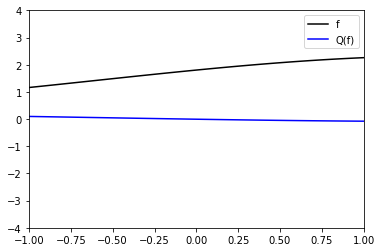

Volume is 3.544907808303833


In [81]:
idx=np.random.randint(train_data_f.shape[0])
plt.plot(grid.cpu(), train_data_f[idx], 'k')
plt.plot(grid.cpu(), train_data_Q[idx], 'b')
plt.legend(["f", "Q(f)"])
plt.xlim(-1,1)
plt.ylim(-4,4)
plt.show()
print("Volume is {}".format(torch.sum(train_data_f[idx]*quad_w.detach().cpu()).item()))

In [44]:
### Model
models=[]
n_basiss=[]
for idx_model, model in enumerate(list_filename):
    args=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/args.bin')
    gparams = args.__dict__
    branch_hidden=gparams['branch_hidden']
    trunk_hidden=gparams['trunk_hidden']
    act=gparams['act']
    output_d_out=gparams['d_out']
    if gparams['use_bias']=='no':
        use_bias=False
    else:
        use_bias=gparams['use_bias']    
    if gparams['use_bias']=='no' and gparams['use_gram']==False:
        n_basis=trunk_hidden[-1]
    else:
        n_basis=trunk_hidden[-1]+1
    use_gram=gparams['use_gram']
    ## Set model
    if gparams['model']=='deeponet':
        DeepONet=deeponet(branch_hidden, trunk_hidden, act, output_d_out, use_bias, use_gram, quad_w, size_domain).cuda()
        save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/best.bin')
        DeepONet.load_state_dict(save_model['state_dict'])
    print(save_model['epoch'])
    print(save_model['best_rel_test'])
    models.append(DeepONet) 
    n_basiss.append(n_basis)

8850
tensor(0.0137)
9650
tensor(0.0142)
9650
tensor(0.0265)
9950
tensor(0.0120)
6650
tensor(0.0102)


In [45]:
save_model.keys()

dict_keys(['state_dict', 'best_loss', 'best_rel_train', 'best_rel_test', 'epoch'])

In [9]:
def final_lr(epochs, lr, step_size, lr_sche):
    return lr, lr*lr_sche**(epochs/step_size)
 

In [10]:
final_lr(10000,1e-3,100,0.9)

(0.001, 2.6561398887587545e-08)

In [11]:
final_lr(10000,1e-3,500,0.9)

(0.001, 0.00012157665459056935)

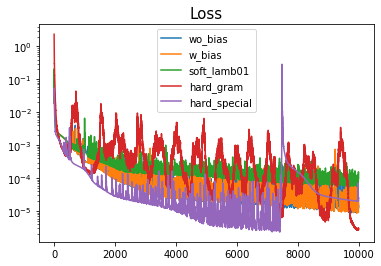

In [12]:
plt.title("Loss", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['loss'], label=names[idx_model])
plt.yscale('log')
plt.legend()

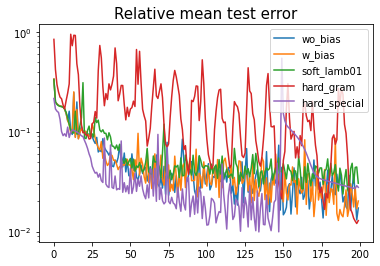

In [13]:
plt.title("Relative mean test error", fontsize=15)
for idx_model, model in enumerate(list_filename):
    save_model=torch.load('results/'+f'{str(dimension)}D/'+f"{gparams['data_file']}/"+list_filename[idx_model]+'/final.bin')
    plt.plot(save_model['rel_test'], label=names[idx_model])
plt.yscale('log')
plt.legend()

### Plot basis

In [14]:
all_basis=[]
add_one_basis=[False,True,True,True,True]
for idx in range(len(models)):
    basis=models[idx].get_basis(grid, add_one_basis=add_one_basis[idx]).transpose(0,1).detach().cpu()
    all_basis.append(basis)
    

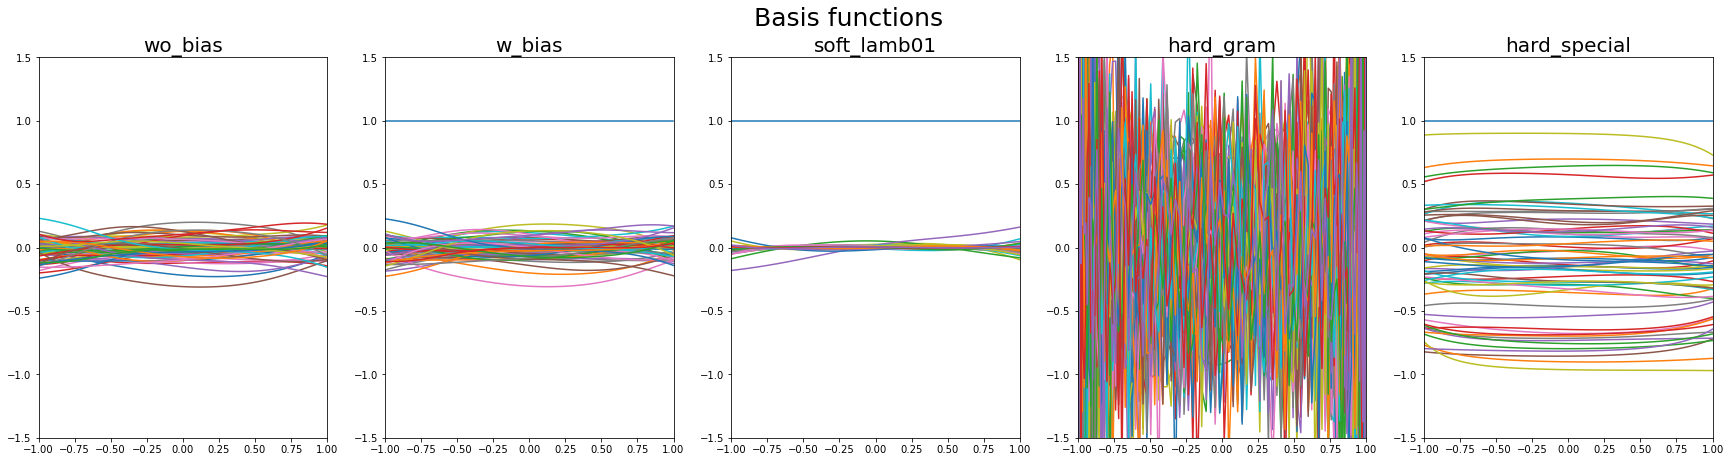

In [15]:
plt.figure(figsize=(30,7))
plt.suptitle(r'Basis functions', fontsize=25)
for idx in range(len(models)):
    ax=plt.subplot(1,len(models),idx+1)
    ax.set_title(names[idx], fontsize=20)
    for i in range(n_basiss[idx]):
        ax.plot(grid.detach().cpu(),all_basis[idx][i], label='{}-th basis'.format(i))
    ax.set_xlim(-1,1)
    ax.set_ylim(-1.5,1.5)
# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
plt.show()

In [16]:
idx=3
for i in range(n_basiss[idx]):
    for j in range(n_basiss[idx]):
        if j!=i:
            print(i, j, torch.abs(torch.sum(all_basis[idx][i]*all_basis[idx][j]*quad_w.detach().cpu())))

0 1 tensor(1.6089e-07)
0 2 tensor(1.2654e-06)
0 3 tensor(1.6252e-06)
0 4 tensor(6.9505e-06)
0 5 tensor(9.6350e-05)
0 6 tensor(0.0003)
0 7 tensor(0.0026)
0 8 

tensor(0.0077)
0 9 tensor(0.0020)
0 10 tensor(0.0299)
0 11 tensor(0.4646)
0 12 tensor(0.1534)
0 13 tensor(0.3621)
0 14 tensor(0.3486)
0 15 tensor(0.2828)
0 16 tensor(0.1052)
0 17 tensor(0.0035)
0 18 tensor(0.1103)
0 19 tensor(0.0079)
0 20 tensor(0.2791)
0 21 tensor(0.0371)
0 22 tensor(0.0238)
0 23 tensor(0.2214)
0 24 tensor(0.2314)
0 25 tensor(0.2084)
0 26 tensor(0.1185)
0 27 tensor(0.0182)
0 28 tensor(0.0094)
0 29 tensor(0.0264)
0 30 tensor(0.0854)
0 31 tensor(0.0847)
0 32 tensor(0.1106)
0 33 tensor(0.1306)
0 34 tensor(0.0008)
0 35 tensor(0.0009)
0 36 tensor(0.0689)
0 37 tensor(0.0521)
0 38 tensor(0.0345)
0 39 tensor(0.1001)
0 40 tensor(0.0106)
0 41 tensor(0.0380)
0 42 tensor(0.0948)
0 43 tensor(0.0743)
0 44 tensor(0.0517)
0 45 tensor(0.0102)
0 46 tensor(0.0261)
0 47 tensor(0.0126)
0 48 tensor(0.0073)
0 49 tensor(0.0128)
0 50 tensor(0.0583)
0 51 tensor(0.0225)
0 52 tensor(0.0048)
0 53 tensor(0.0409)
0 54 tensor(0.0459)
0 55 tensor(0.1069)
0 56 tensor(0.0425)
0 57 tensor(0.0155)
0 58 t

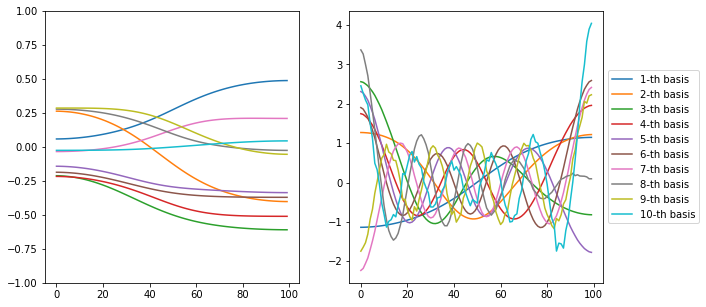

In [17]:
idx=3
num_basis=10

plt.figure(figsize=(10,5))

ax=plt.subplot(1,2,1)
for i in range(num_basis):
    ax.plot(models[idx].trunk_list(grid)[:,i].detach().cpu())
ax.set_ylim(-1,1)


ax=plt.subplot(1,2,2)
for i in range(1,num_basis+1):
    ax.plot(all_basis[3][i], label='{}-th basis'.format(i))
#ax.set_ylim(-1,1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)


In [18]:
def rel_L2_error(pred, true):
    return (torch.sum((true-pred)**2, dim=-1)/torch.sum((true)**2, dim=-1))**0.5

Mean_test error of total test data for wo_bias     =1.37E-02
Mean_test error of total test data for w_bias      =1.42E-02
Mean_test error of total test data for soft_lamb01 =2.65E-02
Mean_test error of total test data for hard_gram   =1.20E-02
Mean_test error of total test data for hard_special=1.02E-02


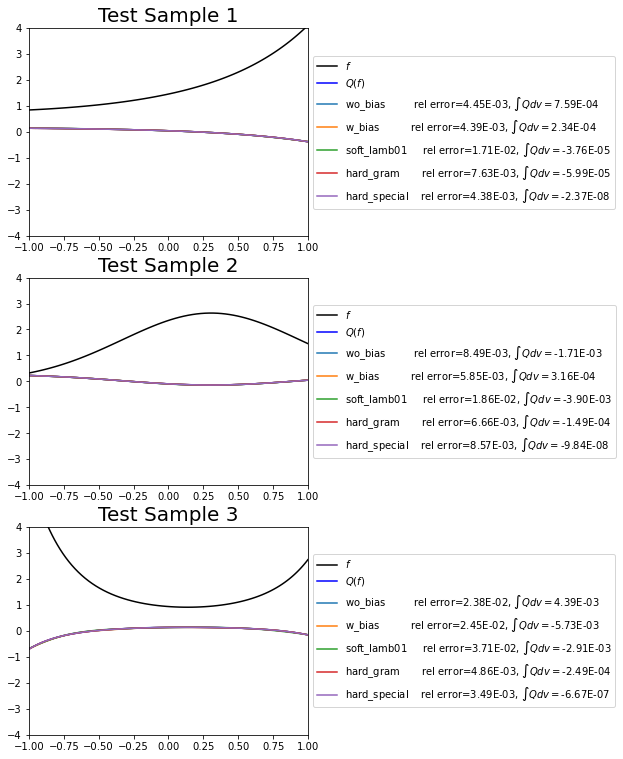

In [19]:
num_plot=3
plt.figure(figsize=(5,13))

for plot_idx in range(num_plot):
    ax=plt.subplot(num_plot,1,plot_idx+1)
    ax.set_title("Test Sample {}".format(str(plot_idx+1)), fontsize=20)
    data_idx=np.random.randint(test_data_f.shape[0])
    
    ax.plot(grid.detach().cpu(), test_data_f[data_idx], '-k', label=r'$f$')
    ax.plot(grid.detach().cpu(), test_data_Q[data_idx], 'b', markersize=3, label=r'$Q(f)$')
    ax.set_xlim(-1,1)
    ax.set_ylim(-4,4)
    for idx in range(len(models)):
        prediction=models[idx](test_data_f[data_idx].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu()
        ax.plot(grid.detach().cpu(), prediction, label=r"{:15s} rel error={:.2E}, $\int Q dv=${:.2E}".format(names[idx],rel_L2_error(prediction, test_data_Q[data_idx]),torch.sum(prediction*quad_w.detach().cpu())))
        if plot_idx==0:
            prediction_all=models[idx](test_data_f.cuda(), grid).squeeze().detach().cpu()
            print("Mean_test error of total test data for {:12s}={:.2E}".format(names[idx], rel_L2_error(prediction_all, test_data_Q).mean()))
#         print(names[idx])
#         print("Rel error : {:.3f}".format(rel_L2_error(prediction, test_data_Q[data_idx])))
#         print(r'$\int Q dv=${:.5f}'.format(torch.sum(prediction*quad_w.detach().cpu())))
#         print(" ")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()

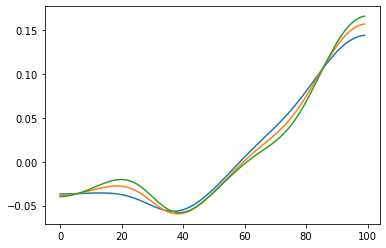

In [57]:
plt.plot(models[0](5*test_data_f[0].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu())
plt.plot(models[0](10*test_data_f[0].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu())
plt.plot(models[0](20*test_data_f[0].reshape(1,1,-1).cuda(), grid).squeeze().detach().cpu())